<a href="https://colab.research.google.com/github/kramorov/kramorov/blob/main/_18_Light_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание Lite

Используйте готовый ноутбук с занятия.

* Сделайте более мощный CVAE, обучите больше эпох до более низкого уровня ошибки и сравните изображения, которые получаются в итоге. Коррелирует ли уровень ошибки с качеством изображений?
* Подайте 5 раз в decoder CVAE один и тот же случайный вектор и любой label от 0 до 9 на выбор. Посмотрите, что сгенерирует CVAE.
* Пояснение: Автокодировщики работают следующим образом: сначала, энкодер кодирует данные в n-мерное пространство (выход энкодера), и кодированные данные подаются на вход декодера, чтобы сгенерить новую картинку.

Для выполнение данного пункта, нужно провести следующий эксперимент:

1. Обучите автокодировщик

2. Разбейте его на 2 отдельные модели: энкодер и декодер. Далее понадобится только декодер

3. На вход декодера подайте 5 векторов из рандомных чисел и выведите на экран получившиеся изображения

In [69]:
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данных
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
import seaborn as sns # более высокоуровневое API на базе библиотеки matplotlib
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами
#from keras.datasets import fashion_mnist # загружаем готовую базу mnist(fashion- с одеждой, обувью и т.п)

from tensorflow.keras.datasets import mnist # загружаем готовую стандартную базу рукописных цифр mnist
from tensorflow.keras.optimizers import Adam, RMSprop # загружаем выбранные оптимизаторы
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Layer, concatenate  
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda, Conv2DTranspose, Conv2D, MaxPool2D
from tensorflow.keras.models import Model # загружаем абстрактный класс базовой модели сети от кераса
from tensorflow.keras.losses import binary_crossentropy # импортируем функцию потерь
from tensorflow.keras.utils import to_categorical


from tensorflow.keras import backend as K 
from tensorflow.keras import metrics as K_metrics
from tensorflow import GradientTape
from tensorflow import math as tf_math

from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard # импортируем коллбэки


In [70]:
from google.colab import drive #модуль для работы с google диском
drive.mount('/content/drive/') # монтируем google диск

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [92]:
def plotImages(xTrain, pred, title='', shape=(112, 80)): # создадим функцию для вывода изображений как картинок
  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(14, 7)) # указываем размеры фигуры
  
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.suptitle(title, y=0.93)
  plt.show()

# Вариационный автокодировщик с условием (CVAE)
Модель собрана на основе ООП TensorFlow.<br>
Основное отличие от VAE это два входных потока данных: первый - изображения, второй - метки изображений.

При инициализации, на вход модели подаются:<br>
* **input_shape** - размерность входного тензора (для MNIST цифры - (28, 28,1)
* **latent_layer_dim** - размерность латентного слоя
* **reconstruction_loss_weight** - доля reconstruction_loss в общем loss **(должна быть в диапазоне от 0 до 1)**. При расчете функции потерь, мы используем 2 веса - один для reconstruction_loss, второй для kl_loss. В сумме они равны 1. Вес для kl_loss рассчитывается при инициализации класса модели.

Для вычисления loss и обновления градиента используется собственная функция.
Поскольку оценка ошибки осуществляется на основании собственной функции, **при вызове метода fit передавать x_test не нужно**.

При использовании классов Model, Layer в качестве родителей для самописных классов, TensorFlow требует, чтобы в коде самописного класса была определен метод класса **call** для выполнения кода класса

In [72]:
class MyCvae(Model):
  class MyEpsilon(Layer):
    def call (self, z_mean, z_log_var, latent_dim):# При использовании класса Layer в качестве родителей для самописных классов, 
                        # TensorFlow требует, чтобы в коде самописного класса была определен метод класса **call** 
                        # для выполнения кода класса
      epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=1.)
      return z_mean + K.exp(z_log_var) * epsilon
  def __init__(self, input_shape, latent_layer_dim, num_classes, reconstruction_loss_weight, **kwargs):
    super().__init__(**kwargs)
    self.shape_before_flatten = 0
    self.shape_after_flatten = 0 
    self.latent_dim=latent_layer_dim
    self.num_classes = num_classes
    self.encoder = self.get_encoder(input_shape, latent_layer_dim, num_classes)
    self.decoder = self.get_decoder(latent_layer_dim, num_classes)

    self.add_epsilon = self.MyEpsilon()
    self.total_loss_tracker = K_metrics.Mean(name="total_loss")  # Здесь обьявляем тип внутренней переменной. Метрики имеют состояния, нужен инстанс класса
    self.reconstruction_loss_tracker = K_metrics.Mean(name="reconstruction_loss") # Здесь обьявляем тип внутренней переменной
    self.kl_loss_tracker = K_metrics.Mean(name="kl_loss") # Здесь обьявляем тип внутренней переменной
    self.reconstruction_loss_weight=reconstruction_loss_weight  
    self.kl_loss_weight= 1- self.reconstruction_loss_weight

  def call(self, input_params_list): # При использовании класса Model в качестве родителей для самописных классов, 
                      # TensorFlow требует, чтобы в коде самописного класса была определен метод класса **call** 
                      # для выполнения кода класса
    data, class_vector = input_params_list
    encoded_data = self.encoder(input_params_list)
    decoded_data = self.decoder([encoded_data[0],class_vector]) 
    return decoded_data      

  def get_encoder(self, input_shape, latent_layer_dim, num_classes):
    input_encode=Input(shape=input_shape) # Если на входе 28, 28,1 то выход далее 28, 28,1
    input_labels_encode = Input(shape=(num_classes,), dtype='float32') # второй вход в энкодер по количеству классов

    x_encode = Conv2D(32, 3, padding='same', activation='relu')(input_encode) # output shape = 28, 28, 32
    #x_encode = MaxPool2D(2, name='MP_1')(x_encode)
    x_encode = Conv2D(64, 3, strides=(2,2), padding='same', activation='relu')(x_encode) # Генерализуем изображение output shape = 14, 14, 64 (strides=(2,2))
    #x_not_flatten = MaxPool2D(2, name='MP_2')(x_encode)
    x_encode = Conv2D(64, 3, padding='same', activation='relu')(x_encode)
    x_not_flatten = Conv2D(64, 3, padding='same', activation='relu')(x_encode)
    #x_not_flatten = MaxPool2D(2)(x_not_flatten)
    self.shape_before_flatten = K.int_shape(x_not_flatten) # х.з что сюда приедет при других входных размерностях
    x_encode_flatten=Flatten()(x_not_flatten) # output shape = 14*14*64 = 12544

    x_encode_concatinated = concatenate([x_encode_flatten, input_labels_encode]) # конкатенируем входы 
    
    x_encode_concatinated = Dense(256, activation='relu')(x_encode_concatinated) # полносвязный слой на 256 нейронов

    self.shape_after_flatten = K.int_shape(x_encode_flatten)

    x_encode_concatinated=Dense(32, activation='relu')(x_encode_concatinated) # output shape = 32
    z_mean = Dense(latent_layer_dim, name='z_mean')(x_encode_concatinated) # shape = 2 = latent_layer_dim
    z_log_var = Dense(latent_layer_dim, name='z_log_var')(x_encode_concatinated)  #  shape = 2 = latent_layer_dim
    encoder=Model([input_encode,input_labels_encode], [z_mean, z_log_var], name = 'encoder')

    return encoder

  def get_decoder(self, latent_layer_dim, num_classes):
    shape_without_batch=self.shape_before_flatten[1:] # Убираем первое None (batch) в 
    first_dense_dim=np.prod(shape_without_batch) # Размерность после Flatten в энкодере
    
    latent_inputs =Input(shape=(latent_layer_dim,), name='Inp_latent')
    input_labels_decode = Input(shape=(num_classes,), dtype='float32', name='Inp_labels') # задаем вторую входную размерность по номеру классов
    
    merged_input = concatenate([latent_inputs, input_labels_decode]) # конкатенируем входы

    x_decode=Dense(32, activation='relu')(merged_input) # output shape = 32
    x_decode=Dense(128, activation='relu')(x_decode) # output shape = 32
    #x_decode=Dense(self.shape_after_flatten[1:], activation='relu')(x_decode)
    #x_decode=Dense(self.shape_after_flatten[1], activation='relu')(x_decode) # 3136
    x_decode=Dense(first_dense_dim, activation='relu')(x_decode)
    x_decode_not_flatten=Reshape(shape_without_batch)(x_decode) # Возвращаем размерность как до Flatten, для дальнейшей обработки (7,7,64)
    #x_decode_not_flatten = Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu')(x_decode_not_flatten) # Делаем обратое преобразование к тому, что мы вытворяли в энкодере
    x_decode_not_flatten = Conv2DTranspose(32, 3, strides=(2,2),padding='same', activation='relu')(x_decode_not_flatten) # Делаем обратое преобразование к тому, что мы вытворяли в энкодере
    #x_decode_not_flatten = Conv2DTranspose(32, (3,3), padding='same', activation='relu')(x_decode_not_flatten) # Делаем обратое преобразование к тому, что мы вытворяли в энкодере
    output_decode =Conv2D(1, 3, padding='same', activation='sigmoid')(x_decode_not_flatten)
    decoder=Model([latent_inputs, input_labels_decode], output_decode, name='decoder')
    #decoder=Model(decoder_params_list, output_decode, name='decoder')
    return decoder  
  @property  # Фактически getter
  def metrics(self):
      return [self.total_loss_tracker,
              self.reconstruction_loss_tracker,
              self.kl_loss_tracker]

  def train_step(self, data):
      data1, class_vector =data[0] # Распаковывае данные по изображению и 
       #= data[1] # В метод FIT в качестве параметра Y мы передаем вектор класса, чтобы можно было его здесь достать и передать в декодер
      #print('Train step ',data1.shape, class_vector.shape)
      #print(len(data[0]), data[0].shape)
      #print(len(data[1]), data[1].shape)
      #print(type(data))
      #print(*data)
      with GradientTape() as tape: 
          z_mean, z_log_var = self.encoder([data1, class_vector])
          new_z_with_epsilon = self.add_epsilon(z_mean, z_log_var,self.latent_dim)
          reconstruction = self.decoder([new_z_with_epsilon, class_vector]) # Прогоняем через декодер значение с добавленной эпсилон (смещение по стандартному нормальному распределению)
          # Оцениваем потери восстановленного декодером значения (с эпсилон)
          reconstruction_loss = tf_math.reduce_mean( # Аналог np.mean. Рассчитывает среднее по элементам тензора в аргументе, возвращает свернутый по указанным осям тензор
                                                #   Поскольку оси мы не указываем, возвращает одномерный тензор
               tf_math.reduce_sum( binary_crossentropy(data1, reconstruction),axis=(1, 2) )  # Аналог np.sum. 
                              # Рассчитывает сумму по элементам тензора в аргументе, возвращает свернутый по указанным осям тензор
                              # Мы указали оси 1,2 возвращает одномерный тензор по каждому элементу батча
              )
          kl_loss = -0.5 * (1 + z_log_var -  tf_math.square(z_mean) -  tf_math.exp(z_log_var))
          total_loss = self.reconstruction_loss_weight*reconstruction_loss +  self.kl_loss_weight*tf_math.reduce_mean(kl_loss)  # Подсчитали свой собственный loss
      grads = tape.gradient(total_loss, self.trainable_weights) # Считаем новые градиенты для весов по собственному loss
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights)) # И прописываем их в модель
      self.total_loss_tracker.update_state(total_loss) # Обновляем свои переменные
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      return {
          "total_loss": self.total_loss_tracker.result(),
          "reconstruction_loss": self.reconstruction_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result(),
      }
  

In [73]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # загружаем данные из базы mnist с разбивкой на train/test

x_train = x_train.astype('float32') / 255. 
x_test  = x_test .astype('float32') / 255. 
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) 

y_train_categorical = to_categorical(y_train, 10).astype(np.float32) 
y_test_categorical  = to_categorical(y_test, 10).astype(np.float32)
num_classes = y_test_categorical.shape[1] # задаем количество классов


##Сделайте более мощный CVAE, обучите больше эпох до более низкого уровня ошибки и сравните изображения, которые получаются в итоге. Коррелирует ли уровень ошибки с качеством изображений?

Epoch 1/10
469/469 [==============================] - 14s 30ms/step - total_loss: 85.0193 - reconstruction_loss: 168.8944 - kl_loss: 1.1440
Epoch 2/10
469/469 [==============================] - 14s 30ms/step - total_loss: 66.2945 - reconstruction_loss: 131.1289 - kl_loss: 1.4602
Epoch 3/10
469/469 [==============================] - 14s 30ms/step - total_loss: 64.6891 - reconstruction_loss: 127.8815 - kl_loss: 1.4967
Epoch 4/10
469/469 [==============================] - 14s 30ms/step - total_loss: 63.9480 - reconstruction_loss: 126.3898 - kl_loss: 1.5062
Epoch 5/10
469/469 [==============================] - 14s 30ms/step - total_loss: 63.5140 - reconstruction_loss: 125.5117 - kl_loss: 1.5163
Epoch 6/10
469/469 [==============================] - 14s 30ms/step - total_loss: 63.2258 - reconstruction_loss: 124.9280 - kl_loss: 1.5235
Epoch 7/10
469/469 [==============================] - 14s 30ms/step - total_loss: 62.9842 - reconstruction_loss: 124.4339 - kl_loss: 1.5347
Epoch 8/10
469/469 [

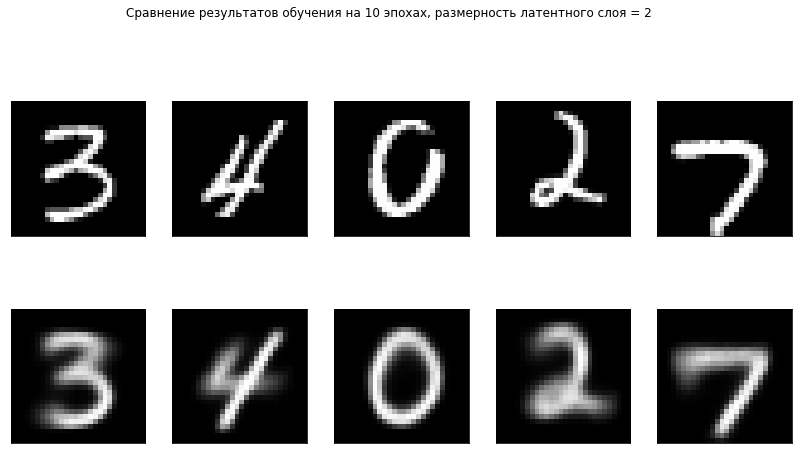

In [91]:
cvae=MyCvae((28,28,1), 2, num_classes, 0.5)
cvae.compile(optimizer=Adam(), run_eagerly=True) # run_eagerly - для запуска своего пересчета градиента
res=cvae.fit([x_train, y_train_categorical], epochs=10, batch_size=128)
x_pred=cvae.predict([x_test, y_test_categorical])
plotImages(x_test, x_pred, 'Сравнение результатов обучения на 10 эпохах, размерность латентного слоя = 2', shape=(28,28))

## Дообучим модель

Epoch 1/10
469/469 [==============================] - 14s 31ms/step - total_loss: 62.2921 - reconstruction_loss: 123.0312 - kl_loss: 1.5530
Epoch 2/10
469/469 [==============================] - 14s 31ms/step - total_loss: 62.1731 - reconstruction_loss: 122.7895 - kl_loss: 1.5567
Epoch 3/10
469/469 [==============================] - 14s 31ms/step - total_loss: 62.0291 - reconstruction_loss: 122.4922 - kl_loss: 1.5660
Epoch 4/10
469/469 [==============================] - 14s 30ms/step - total_loss: 61.9000 - reconstruction_loss: 122.2276 - kl_loss: 1.5724
Epoch 5/10
469/469 [==============================] - 14s 30ms/step - total_loss: 61.7619 - reconstruction_loss: 121.9447 - kl_loss: 1.5789
Epoch 6/10
469/469 [==============================] - 14s 30ms/step - total_loss: 61.6367 - reconstruction_loss: 121.6877 - kl_loss: 1.5858
Epoch 7/10
469/469 [==============================] - 16s 33ms/step - total_loss: 61.5038 - reconstruction_loss: 121.4154 - kl_loss: 1.5921
Epoch 8/10
469/469 [

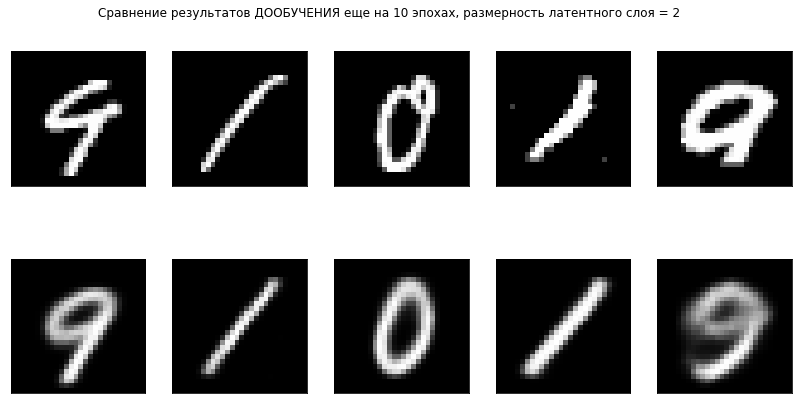

In [93]:
#Дообучим модель
res=cvae.fit([x_train, y_train_categorical], epochs=10, batch_size=128)
x_pred=cvae.predict([x_test, y_test_categorical])
plotImages(x_test, x_pred, 'Сравнение результатов ДООБУЧЕНИЯ еще на 10 эпохах, размерность латентного слоя = 2', shape=(28,28))

##После дообучения модели качество получаемых изображений заметно улучшилось.<br>Теперь посмотрим на вариант с размерностью скрытого пространства = **10**

Epoch 1/10
469/469 [==============================] - 16s 33ms/step - total_loss: 78.5374 - reconstruction_loss: 155.3394 - kl_loss: 1.7350
Epoch 2/10
469/469 [==============================] - 15s 33ms/step - total_loss: 50.5979 - reconstruction_loss: 99.0809 - kl_loss: 2.1148
Epoch 3/10
469/469 [==============================] - 16s 34ms/step - total_loss: 45.3161 - reconstruction_loss: 88.5451 - kl_loss: 2.0871
Epoch 4/10
469/469 [==============================] - 16s 33ms/step - total_loss: 43.0259 - reconstruction_loss: 84.0578 - kl_loss: 1.9940
Epoch 5/10
469/469 [==============================] - 15s 33ms/step - total_loss: 41.7042 - reconstruction_loss: 81.4698 - kl_loss: 1.9386
Epoch 6/10
469/469 [==============================] - 16s 33ms/step - total_loss: 40.8352 - reconstruction_loss: 79.7625 - kl_loss: 1.9079
Epoch 7/10
469/469 [==============================] - 15s 33ms/step - total_loss: 40.1883 - reconstruction_loss: 78.4812 - kl_loss: 1.8953
Epoch 8/10
469/469 [======

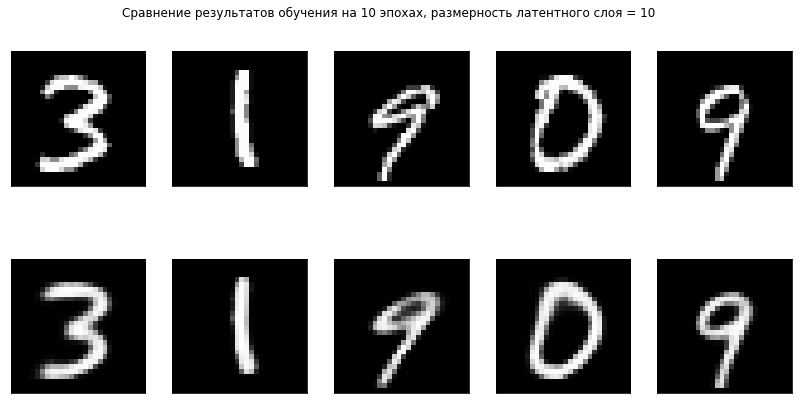

In [94]:
# Вариант с размерностью скрытого пространства = 10
cvae=MyCvae((28,28,1), 10, num_classes, 0.5)
cvae.compile(optimizer=Adam(), run_eagerly=True) # run_eagerly - для запуска своего пересчета градиента
res=cvae.fit([x_train, y_train_categorical], epochs=10, batch_size=128)
x_pred=cvae.predict([x_test, y_test_categorical])
plotImages(x_test, x_pred, 'Сравнение результатов обучения на 10 эпохах, размерность латентного слоя = 10', shape=(28,28))

# Подайте 5 раз в decoder CVAE один и тот же случайный вектор и любой label от 0 до 9 на выбор. Посмотрите, что сгенерирует CVAE.

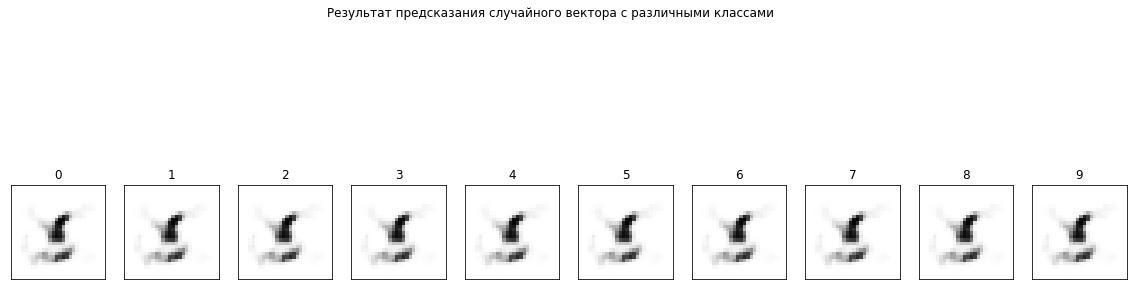

In [95]:
x_rand_vector=np.random.sample((1, 10, 1))
plt.figure(figsize=(20, 7)) # указываем размеры фигуры
for i in range(10):
  y_i=to_categorical(i, 10).astype(np.float32)
  y_i=np.reshape(y_i,(1,10,))
  x_rand_predict=(1-cvae.decoder([x_t, y_t]).numpy())*255
  ax = plt.subplot(1, 10, i + 1) # выведем область рисования Axes
  plt.imshow(x_rand_predict.reshape(28,28)) # отрисуем правильные картинки в размере 112*80      
  plt.gray() # выведем в черно-белом цвете
  ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
  ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  ax.set_title(str(i))
plt.suptitle('Результат предсказания случайного вектора с различными классами', y=0.95)
plt.show()  